In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git  

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-xzx6r_6r
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-xzx6r_6r
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=87ee642f7c9c5535bde05e1f08adcbd4cd034c7583da8afd62448ae945817e0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ap9vmpo/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


In [2]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

import cachetools.func

In [3]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

## ${\textbf{Data Retrieval}}$

In [4]:
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
    # fix region names
    for p in pairs:
        df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])

    return df

    #-----
def merge_df_data(df1,df2):
    return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

    #-----
def str_add_func(*args):      
    out = []
    for x in args:
        if isinstance(x,str):
            out.append(x)

    return '_'.join(out)


class covid_data():
    '''
    Python class to obtain global COVID19 data from 
    John Hopkins GIT repository. This data is updated daily, 
    and the most upto date information available on the web.  
    '''
    def __init__(self,**kwargs):

        #
        nrow = kwargs.get('nrow',None)
        self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)

    @staticmethod
    def create_ts(df):
        ts=df
        columns = ts['region']
        ts=ts.drop(['Province/State', 
                    'Country/Region',
                    'Lat', 
                    'Long',
                    'Population'], 
                   axis=1).set_index('region').T    

        ts.columns = columns 
        ts=ts.fillna(0)
        #
        ts.index.name = 'Date'
        return ts

    def search_agg(self, name,col='Country/Region',ts=True):

        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
              #pd.columns(columns=)
            df_list= []     
            for n in name:
                df = v[v[col]==n].set_index(col).filter(regex='/20')
                df_list.append(df.sum(axis=0))

            df = pd.concat(df_list,axis=1, sort=False)
            df.columns = name
            out[k] = df

      # if ts:                
      #   out[k] = self.create_ts(df)
      # else:
      #   out[k] = df.T

        return out

    def search(self, name,col='Country/Region',ts=True):

        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
            if ts:                
                out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
            else:
                out[k] = v[v[col] in name].T
        return out

    @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
    def get_csseg_data(self, nrow=None):

        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
        path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

        # 

        url = f'{path}/time_series_covid19_confirmed_global.csv'
        confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_deaths_global.csv'
        dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_recovered_global.csv'

        recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
#         print(confirmed.head())
#         print(dead.head())

        #
        return confirmed, dead, recovered

In [5]:
cd = covid_data()
cd.confirmed.head()
countries = ['Senegal']
mm = cd.search_agg(countries)

In [6]:
for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
    df = mm[ctype].stack().reset_index()
    #print(df.head())
    df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        df['date'] = pd.to_datetime(df['date'])
        dfall = df
    else:
        dfall[ctype] = df[ctype]

In [7]:
dfall.head()

,date,country,confirmed,dead,recovered
0,2020-01-22,Senegal,0,0,0
1,2020-01-23,Senegal,0,0,0
2,2020-01-24,Senegal,0,0,0
3,2020-01-25,Senegal,0,0,0
4,2020-01-26,Senegal,0,0,0


In [8]:
dfall.nunique()

date         198
country        1
confirmed    148
dead          85
recovered    137
dtype: int64

In [9]:
dfall.max()

date         2020-08-06 00:00:00
country                  Senegal
confirmed                  10715
dead                         223
recovered                   7101
dtype: object

In [10]:
end_train_date = datetime.datetime(2020, 7, 25)
# train_sen_df = sen_df_confiremed.loc[:end_train_date]
# test_sen_df = sen_df_confiremed.loc[end_train_date:]

# print(train_sen_df.shape, test_sen_df.shape)

In [11]:
df = dfall[dfall['confirmed'] > 100]

In [12]:
df.set_index('date', inplace=True)
df.head()

,country,confirmed,dead,recovered
date,,,,
2020-03-26,Senegal,105,0,9
2020-03-27,Senegal,119,0,11
2020-03-28,Senegal,130,0,18
2020-03-29,Senegal,142,0,27
2020-03-30,Senegal,162,0,27


In [13]:
d_df = df.drop('country', axis=1)
train_df = d_df['confirmed'].loc[:end_train_date]
test_df = d_df['confirmed'].loc[end_train_date:]

print(train_df.shape, test_df.shape)

(122,) (13,)


INFO     [numexpr.utils] NumExpr defaulting to 2 threads.


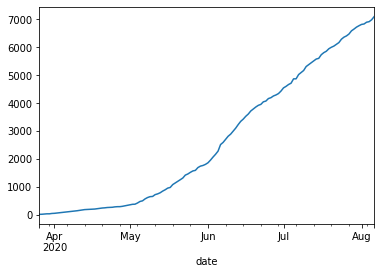

In [14]:
d_df['recovered'].plot()

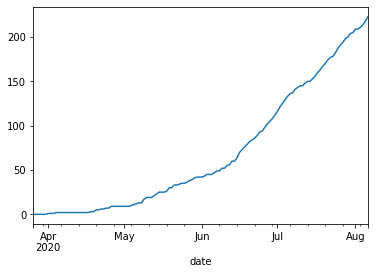

In [15]:
d_df['dead'].plot()

In [ ]:
# jhu = cov19.data_retrieval.JHU()
# jhu.download_all_available_data()

# sen_df = jhu.get_total_confirmed_deaths_recovered('Senegal')
# sen_df.shape

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


(195, 3)

**Filter Data to contain cases greater than or equals to 100**

**Check for missing Dates**

No data with missing dates

**Split the data for inference and validation forecast**

In [ ]:
end_train_date = datetime.datetime(2020, 7, 25)
# train_sen_df = sen_df_confiremed.loc[:end_train_date]
# test_sen_df = sen_df_confiremed.loc[end_train_date:]

# print(train_sen_df.shape, test_sen_df.shape)

(122,) (10,)


In [16]:
bd = datetime.datetime(2020, 3, 26)  # For the date filter
ed = datetime.datetime(2020, 8, 10)

### Create Model
first we need to set the priors for the change points and other configs

In [17]:
diff_data_sim = 18  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 14

In [18]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 15)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 23)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 31)

In [19]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

In [20]:
params_model = dict(
    new_cases_obs=train_df,
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=15e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [21]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [23]:
trace = pm.sample(model=this_model, tune=300, draws=350, cores=3)

Only 350 samples in chain.
WARNING  [pymc3] Only 350 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO     [pymc3] Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
Sampling 3 chains: 100%|██████████| 1950/1950 [3:07:02<00:00,  5.76s/draws]
The

## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


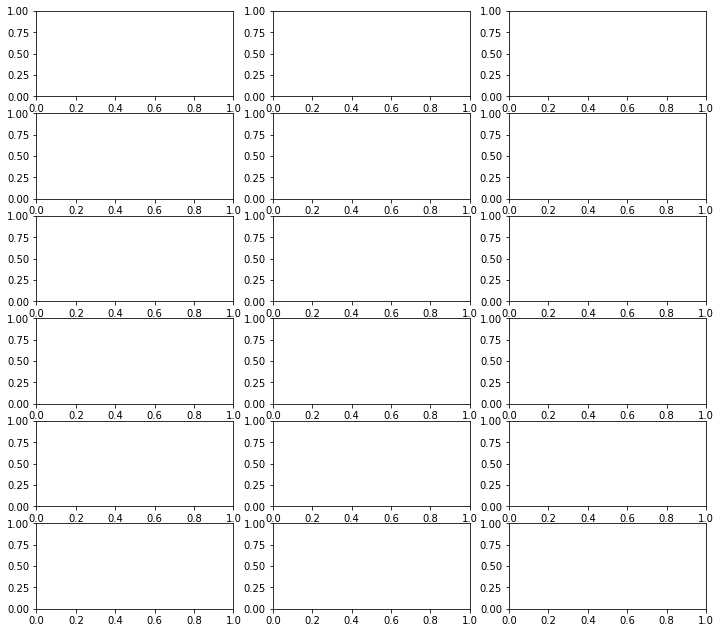

In [24]:
fig, axes = plt.subplots(6, 3, figsize=(12, 11))
varnames = this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [25]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0]) 

In [26]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

In [27]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

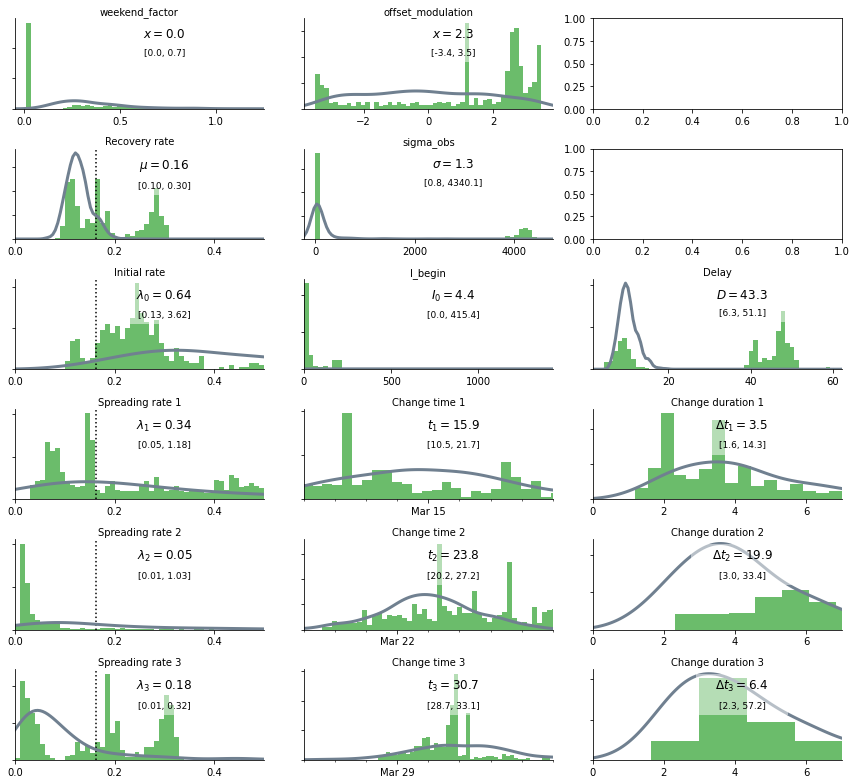

In [28]:
fig.tight_layout()
fig #To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


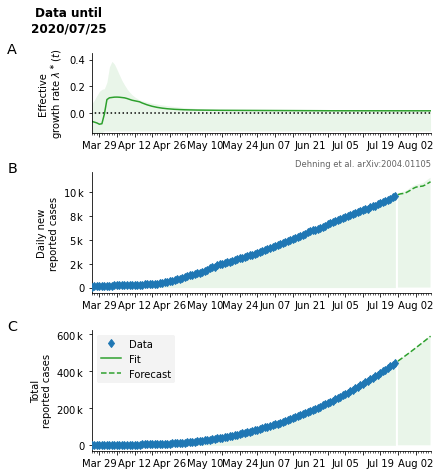

In [29]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)

### Get Policies Implemented by Countries

In [30]:
gov_pol = cov19.data_retrieval.OxCGRT()
gov_pol.download_all_available_data()

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/OxCGRT.csv.gz successful.


In [34]:
gov_pol.get_possible_policies()

{'containment and closure policies': ['C1_School closing',
  'C2_Workplace closing',
  'C3_Cancel public events',
  'C4_Restrictions on gatherings',
  'C5_Close public transport',
  'C6_Stay at home requirements',
  'C7_Restrictions on internal movement',
  'C8_International travel controls'],
 'economic policies': ['E1_Income support',
  'E2_Debt/contract relief',
  'E3_Fiscal measures',
  'E4_International support'],
 'health system policies': ['H1_Public information campaigns',
  'H2_Testing policy',
  'H3_Contact tracing',
  'H4_Emergency investment in healthcare',
  'H5_Investment in vaccines'],
 'miscellaneous policies': ['M1_Wildcard']}

In [35]:
gov_pol.get_possible_countries()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei', 'Bhutan', 'Botswana', 'Central African Republic',
       'Canada', 'Switzerland', 'Chile', 'China', "Cote d'Ivoire",
       'Cameroon', 'Democratic Republic of Congo', 'Congo', 'Colombia',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Cayman Islands', 'Cyprus',
       'Czech Republic', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Eritrea',
       'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France',
       'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Gibraltar',
       'Guinea', 'Gambia', 'Greece', 'Greenland', 'Guatemala', 'Guam',
       'Guyana', 'Hong Kong', 'Hon

In [41]:
gov_pol.get_change_points(policies='C1_School closing', country='Senegal')

[{'date': Timestamp('2020-03-16 00:00:00'),
  'indicator_after': 3.0,
  'indicator_before': 0.0,
  'policy': 'C1_School closing'},
 {'date': Timestamp('2020-06-25 00:00:00'),
  'indicator_after': 2.0,
  'indicator_before': 3.0,
  'policy': 'C1_School closing'}]